In [1]:
import numpy as np
import os
from run_xde import run_xde
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from scipy.spatial import KDTree

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



### Setting up environment and loading the trained model

In [2]:
inpt = np.genfromtxt('postproc_inp',dtype='str',max_rows=1)
inp  = np.loadtxt('postproc_inp',skiprows=2)

if inp.ndim == 1:
    inp = np.reshape(inp,(1,inp.shape[0]))
act = {1:"tanh", 2:"relu"}
lr, lyr, wid, actv, epch, n, lossw1, lossw2, lossw3, losswa, nxm, nym, bctype = inp.T

Re = 590378.378378
ndim = 2
nvar = 7

In [3]:
c = 0  # Which input line you want to postprocess
xde_params  = [ndim, nvar, int(epch[c]), int(n[c]), lossw1[c], lossw2[c], lossw3[c], losswa[c]]
data_params = [Re, int(nxm[c]), int(nym[c]), bctype[c]]
nn_params   = [lr[c], int(lyr[c]), int(wid[c]), act[actv[c]]]
fold_name = []
fold_name.append(p2s(inpt, inp[c,:]))
file_name = 'file'

In [4]:
model, X, Y, xs, ys, x_coor, y_coor = run_xde(xde_params, data_params, nn_params, fold_name[0], file_name, cudev=0)

[1. 1.]
[0.05050505 0.05797101]
Loss weights  [1.0, 1.0, 1.0]
Compiling model...
Building feed-forward neural network...
'build' took 0.065742 s



/home/sheel/anaconda3/lib/python3.6/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sheel/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.496441 s

Restoring model from ../runs/lr0.0001_lyr4_wid20_actv1_epchs100000_n50_wp11_wp21_wp31_wa100_nxm5_nym32_bctype2/file.ckpt-100000.ckpt ...

INFO:tensorflow:Restoring parameters from ../runs/lr0.0001_lyr4_wid20_actv1_epchs100000_n50_wp11_wp21_wp31_wa100_nxm5_nym32_bctype2/file.ckpt-100000.ckpt


### Post-processing of model output

In [8]:

output_pred = model.predict(X)
Xgrid   = np.tile(x_coor,(y_coor.shape[0], 1))
Ygrid   = np.tile(y_coor,(x_coor.shape[0], 1)).T
Upred   = ys[0]*output_pred[:,0:1]
Vpred   = ys[1]*output_pred[:,1:2]
uupred  = ys[2]*output_pred[:,2:3]
vvpred  = ys[3]*output_pred[:,3:4]
wwpred  = ys[4]*output_pred[:,4:5]
uvpred  = ys[5]*output_pred[:,5:6]
Ppred   = ys[0]*ys[0]*output_pred[:,6:7]

U       = ys[0]*Y[:,0:1]
V       = ys[1]*Y[:,1:2]
uu      = ys[2]*Y[:,2:3]
vv      = ys[3]*Y[:,3:4]
ww      = ys[4]*Y[:,4:5]
uv      = ys[5]*Y[:,5:6]

error_U  = np.linalg.norm(Upred-U,2)/np.linalg.norm(U,2)*100
error_V  = np.linalg.norm(Vpred-V,2)/np.linalg.norm(V,2)*100
error_uu = np.linalg.norm(uupred-uu,2)/np.linalg.norm(uu,2)*100
error_vv = np.linalg.norm(vvpred-vv,2)/np.linalg.norm(vv,2)*100
error_ww = np.linalg.norm(wwpred-ww,2)/np.linalg.norm(ww,2)*100
error_uv = np.linalg.norm(np.abs(uvpred)-np.abs(uv),2)/np.linalg.norm(uv,2)*100

Ugrid  =  np.reshape(Upred,   [np.size(y_coor,0), np.size(x_coor,0)])
Vgrid  =  np.reshape(Vpred,   [np.size(y_coor,0), np.size(x_coor,0)])
uugrid =  np.reshape(uupred,  [np.size(y_coor,0), np.size(x_coor,0)])
vvgrid =  np.reshape(vvpred,  [np.size(y_coor,0), np.size(x_coor,0)])
wwgrid =  np.reshape(wwpred,  [np.size(y_coor,0), np.size(x_coor,0)])
uvgrid =  np.reshape(uvpred,  [np.size(y_coor,0), np.size(x_coor,0)])

U       =  np.reshape(U,    [np.size(y_coor,0), np.size(x_coor,0)])
V       =  np.reshape(V,    [np.size(y_coor,0), np.size(x_coor,0)])
uu      =  np.reshape(uu,   [np.size(y_coor,0), np.size(x_coor,0)])
vv      =  np.reshape(vv,   [np.size(y_coor,0), np.size(x_coor,0)])
ww      =  np.reshape(ww,   [np.size(y_coor,0), np.size(x_coor,0)])
uv      =  np.reshape(uv,   [np.size(y_coor,0), np.size(x_coor,0)])

In [9]:
print(error_U, error_V, error_uu, error_vv, error_ww, error_uv)

182.73936956837383 99.99903978636495 256.3583152245762 70.48535634286237 75.39707800032369 99.78877078831563


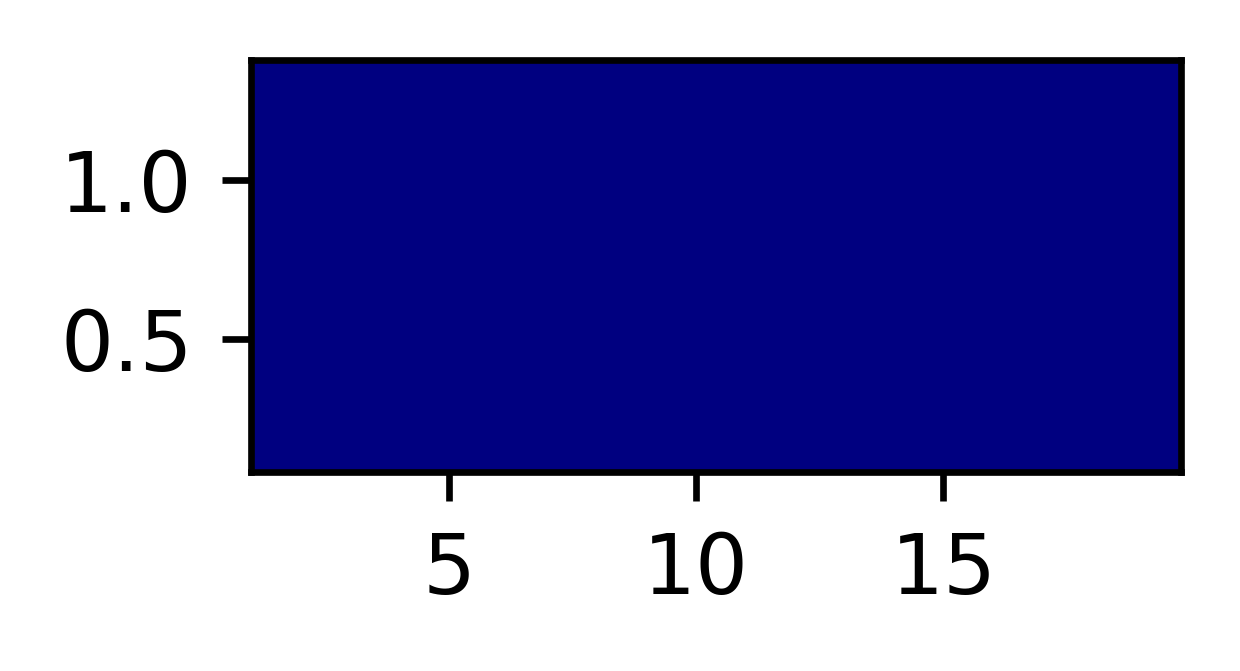

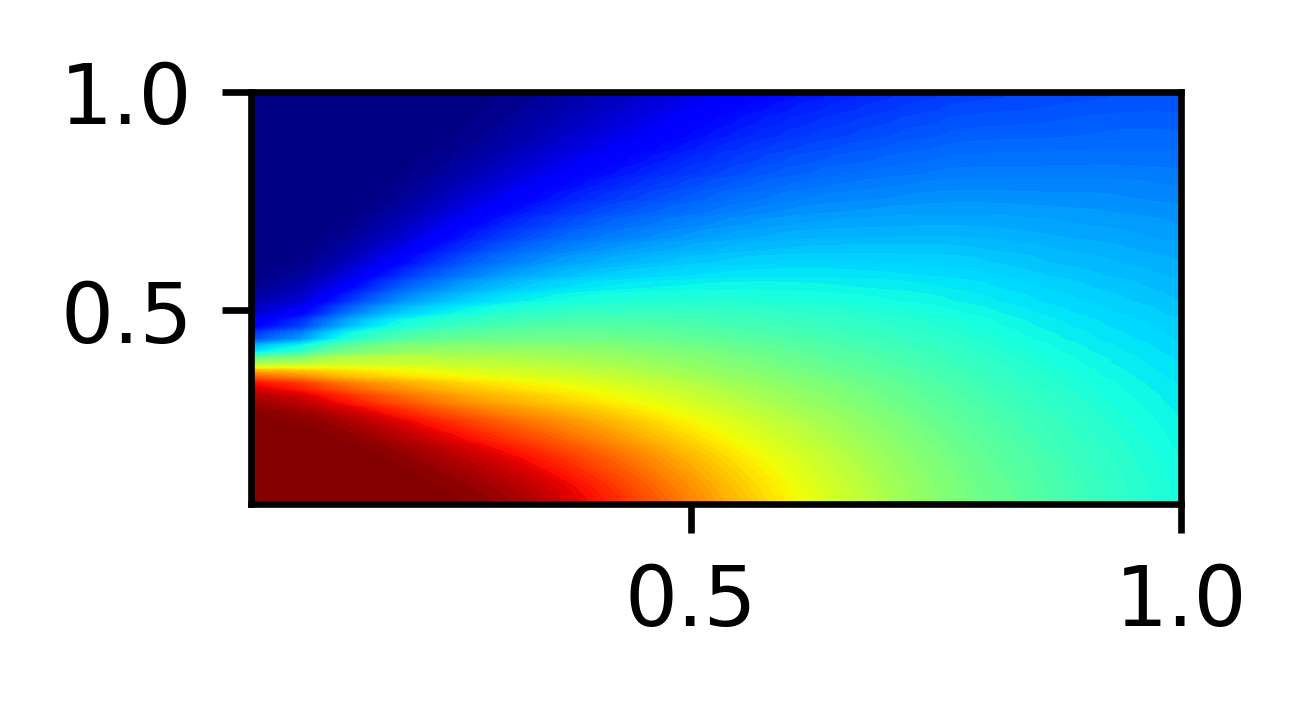

In [12]:
### Contour plots at a given station

fig = plt.figure(figsize=(2,2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(abs(U)),np.max(abs(U)),100)
cs0 = ax.contourf(Xgrid*xs[0], Ygrid*xs[1], Ugrid, levels=lvls, cmap='jet', extend = 'both')

fig = plt.figure(figsize=(2,2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(abs(U)),np.max(abs(U)),100)
cs0 = ax.contourf(Xgrid, Ygrid, U, levels=lvls, cmap='jet', extend = 'both')


In [ ]:
np.linspace(Xgrid[0,0]*xs[0], Xgrid[0,-1]*xs[0], 5)

In [ ]:
Nx_anchor = 5; Ny_anchor = 32

Xloc = X.copy()

Xloc[:,0] = Xloc[:,0]*xs[0]
Xloc[:,1] = Xloc[:,1]*xs[1]

x_coor_anchors  = np.linspace(x_coor[0], x_coor[-1], Nx_anchor)   # Concentrating anchor points in the transitional layer only
y_coor_anchors  = np.linspace(y_coor[0], y_coor[-1], Ny_anchor)

Xgrid_anchors   = np.tile(x_coor_anchors,(Ny_anchor, 1))
Ygrid_anchors   = np.tile(y_coor_anchors,(Nx_anchor, 1)).T

X_star_anchors  = np.hstack((Xgrid_anchors.flatten()[:,None], Ygrid_anchors.flatten()[:,None]))
kdtree          = KDTree(Xloc)

d, idx_anchors  = kdtree.query(X_star_anchors)